# Lossless FDTD Wave Equation Simulation Without Lip Coupling

In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import math
from IPython.display import Audio

In [3]:
# Constants
sr  = 44100         # Sample rate
gps = 9             # Grids per sample
c0  = 340           # Speed of sound
h   = 0.001         # Spatial grid size
k   = 1 / gps / sr  # Temporal grid size
lam = c0 * k / h    # Courant's number
assert lam <= 1
num_sgrid = 501

lam

0.856638951877047

501


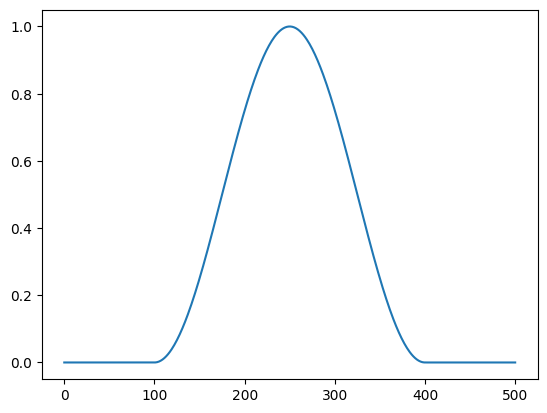

In [4]:
# Create initial waveform

# Hann window with padding
window_length = 300
window = torch.hann_window(window_length)
padding_size = (num_sgrid - window_length) / 2
wave = np.pad(window, (math.floor(padding_size), math.ceil(padding_size)))

# Hann window w/o padding
# wave = torch.hann_window(num_sgrid)

# Sine wave
# wave = np.sin(np.linspace(0, 2 * np.pi, num_sgrid, endpoint=False), dtype=np.float32)

# Triangular wave
# wave = np.pad(np.linspace(0, 1, 100, endpoint=False, dtype=np.float32), (0, 401)) + \
#        np.pad(np.linspace(1, 0, 401, endpoint=True, dtype=np.float32), (100, 0))

# print(len(wave))

# plt.plot(wave)

In [5]:
# Construct matrix B
matB = torch.diag(torch.ones(num_sgrid) * 2 * (1 - lam**2)) + \
       torch.diag(torch.ones(num_sgrid - 1) * lam**2, diagonal=1) + \
       torch.diag(torch.ones(num_sgrid - 1) * lam**2, diagonal=-1)

matBn = matB.clone()  # Neumann
matBd = matB.clone()  # Dirichlet

matBn[0][0] = matBn[-1][-1] = 2 - lam**2
matBd[0][0] = matBd[0][1] = matBd[1][0] = matBd[-1][-1] = matBd[-1][-2] = matBd[-2][-1] = 0

matBn

tensor([[1.2662, 0.7338, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.7338, 0.5323, 0.7338,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.7338, 0.5323,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.5323, 0.7338, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.7338, 0.5323, 0.7338],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.7338, 1.2662]])

In [20]:
# Update the wave function for each timestep
nsteps = 1001
steps_per_frame = 10
pre_steps = 0

w_now = wave
w_prev = wave
time = 0


def step():
    global k, time, w_now, w_prev
    w_next = matBn @ w_now - w_prev  # Dirichlet boundary
    w_prev = w_now
    w_now = w_next
    time += k

def animate(t):
    line.set_ydata(w_now)
    for _ in range(steps_per_frame):
        step()
    return ax,


for _ in range(pre_steps):
    step()


# Generate an animated plot of the wave function.
# We must close plt so that the plot generated by itself won't be displayed.
# Instead, we only want the animation to appear, which is done by the last line.
fig, ax = plt.subplots()
ax.set_ylim((-1, 1))
line, = ax.plot(w_now)
plt.close()

plt.rcParams["animation.html"] = "jshtml"
FuncAnimation(fig, animate, frames=int(nsteps / steps_per_frame))

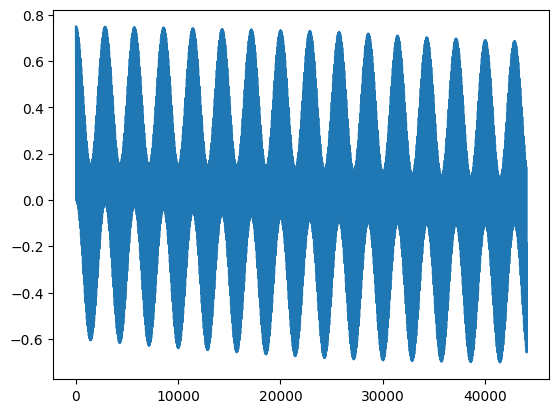

In [104]:
# Generate simuated sound

nsamples    = 1 * sr
nsteps      = nsamples * gps
pickup_pos  = 200

w_now = wave
w_prev = wave

def step():
    global w_now, w_prev
    w_next = matBn @ w_now - w_prev
    w_prev = w_now
    w_now = w_next

sound = np.zeros(nsamples)

for i in range(nsamples):
    sound[i] = w_now[pickup_pos]
    for _ in range(gps):
        step()

plt.plot(sound)
display(Audio(sound, rate=sr))

In [44]:
# Sine waves for comparison

sine340 = np.sin(np.linspace(0, 2 * np.pi * 340, sr))
sine680 = np.sin(np.linspace(0, 2 * np.pi * 680, sr))

display(Audio(sine340, rate=sr))
display(Audio(sine680, rate=sr))

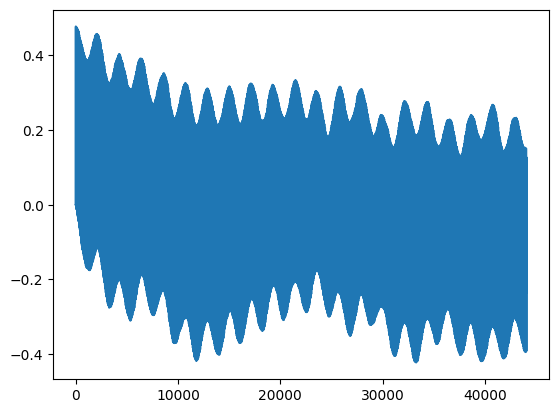

In [90]:
plt.plot(sound)